# COMP47590: Advanced Machine Learning
# Assignment 1: The Super Learner

## Import Packages Etc

In [344]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

import pandas as pd
import numpy as np
from matplotlib import pyplot
from random import randint

from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics

from scipy.spatial import distance
from scipy import stats

from sklearn.base import clone

%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [430]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer 
        and a aggregatnio model at the aggregation layer. 
        A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    
    Attributes
    ----------
    
    Notes
    -----
    
    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = SuperLearnerClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    
    # Constructor for the classifier object
    def __init__(self, estimators, is_predict_proba=False, base_cv=5, 
                 add_original_input=False, stack_learner=DecisionTreeClassifier()):
        
        """Setup a SuperLearner classifier.
        Parameters
        ----------
        estimators : the list contains base learner estimators 
        is_predict_proba : indicate whether the stack learner should be trained on label outputs 
                           from base learners or probability outputs from base learners
        base_cv : define a cv fold for training base learners to avoid overfitting
        add_original_input : indicate whether the original input should be added to the beginning of
                             the training set and the test test of the stack learner
        stack_learner : the initialized estimator for the stack layer
        Returns
        -------

        """     
        
        # initialize base learners for the base layer
        self.estimators = estimators
        
        # initialize the stack learner for the stack layer
        self.stack_learner = stack_learner
        
        # assign the number of folds for training base learners using k-fold CV
        self.base_cv = base_cv
        
        # indicate whether the output of base leaners is proba or pred values.
        self.is_predict_proba = is_predict_proba
        
        # indicate whether adding original input to the dataset of stack learner
        self.add_original_input = add_original_input
        
        
    def fit(self, X, y):
        
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        
        # Check if base learners are assigned
        if self.estimators is None or len(self.estimators) == 0:
            raise AttributeError('Invalid `estimators` attribute, `estimators`'
                                 ' should be a list of (string, estimator)'
                                 ' tuples')
        
        # Check that X and y have correct type
        self.X, self.y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        names, clfs = zip(*self.estimators)
        self.names = names
        
        # check if the estimators are nones
        n_isnone = np.sum([clf is None for _, clf in self.estimators])
        if n_isnone == len(self.estimators):
            raise ValueError('All estimators are None. At least one is '
                             'required to be a classifier!')
        
        # `clone` the estimators with their hyper parameters
        self.estimators_ = [clone(clf) for clf in clfs if clf is not None]
        
        # The training process of the base layer
        self.x_base = self.__fit_base_learners()
        
        # The training process of the stack layer
        self.__fit_stack_learner()
        
        # Return the classifier
        return self
    
    
    def __get_CV_predictions(self, clf_name, clf):
        
        """Peform k-fold cross-validation on each of learners.
        Store and Use fitting learners in each fold to 
        predict test set for prediction of stack learner.
        ----------
        Parameters
        ----------
        clf_name : The name of clf
        clf : The model as a base learner
        ----------
        Return
        ----------
        base_data : array-like matrix of shape = [n_samples, 1]
        """    
        
        # Store each generated clf in each fold in the list, and bind them with the clf name
        self.fold_clf[clf_name] = list()
        k_fold = KFold(n_splits=self.base_cv)
        
        # Convert given X and y to numpy array
        X = np.array(self.X, np.float32)
        y = np.array(self.y, np.float32)
        
        if self.is_predict_proba:
            
            # Create basic array for storing predictions    
            base_data = np.zeros((self.X.shape[0], len(self.classes_)))
            
            for k, (train, test) in enumerate(k_fold.split(X, y)):
                # Clone the estimator to make sure that all the folds are independent
                clf = clone(clf)
                clf.fit(X[train], y[train])
#                 print("[{0} fold {1}] , score: {2:.5f}".format(i, k, clf.score(X[test], y[test])))
                base_data[test] = clf.predict_proba(X[test])
                self.fold_clf[clf_name].append(clf)
                
            return base_data

        else:
            base_data = np.zeros((self.X.shape[0],))
            
            for k, (train, test) in enumerate(k_fold.split(X, y)):
                clf = clone(clf)
                clf.fit(X[train], y[train])
                base_data[test] = clf.predict(X[test])
                self.fold_clf[clf_name].append(clf)
                
            return np.reshape(base_data, (-1,1))    
    
    
    def __fit_base_learners(self):
        
        """Train each of 6 base models on the training set.
        Peform k-fold cross-validation on each of learners 
        and collect the cross-validated predicted values for each model
        Parameters
        cv : the number of folds for the cross-validation
        ----------
        Return
        ----------
        base_data : array-like matrix of shape = [n_samples, n_base_models]
                    The combined n cross-validated predicted values from each base model.
                    This data is used for training the model in the stack layer.
        """

        # ---------- Perform k-fold cross-validation on base learners ----------
        # Using cross_val_predict to get the cross-validated predicted values from each classifier
        # Then using np.column_stack to combine N x 1 arrays as many times as the number of base models
        base_data = np.array([])
        
        # The dict for storing learners of each kind of models in each fold.
        # So when stack learner is predicting, these base learners can work 
        # and generate predictions for stack learner
        # self.fold_clf is like {'base_learn_1':[clf of fold 1, clf of fold 2, ...], ...}
        self.fold_clf = dict()
        
        for name, clf in zip(self.names, self.estimators_):
            k_base_data = self.__get_CV_predictions(name, clf)
            if len(base_data) == 0:
                base_data = k_base_data
            else:
                base_data = np.column_stack((base_data, k_base_data))
                
#         print("base data shape : ", base_data.shape)

        return base_data
            

    def __fit_stack_learner(self):
        
        """Train the stack-layer model on the base data.
        Feed the base data into the stack_layer model to generate the ensemble prediction.
        Parameters
        classification algorithm : default = decision tree, and defined in the contructor
        ----------
        Return
        ----------
        self : object
        """
        
        # add the original features as the first part of training set of stack learner
        if self.add_original_input:
            x_stack_train = np.column_stack((self.X, self.x_base))
        else:
            x_stack_train = self.x_base
        
        self.stack_learner.fit(x_stack_train, self.y)
        
        return self
    
    
    def __generate_pre_on_base(self, X):
        
        """Generate predictions from base learners on full test set
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        
        base_prediction = np.array([])
        
        if self.is_predict_proba:
            base_data = np.zeros((self.X.shape[0], len(self.classes_)))
        else:
            base_data = np.zeros((self.X.shape[0],))
        
        for index, (k,l) in enumerate(self.fold_clf.items()):
            if self.is_predict_proba:
                pre_fold_test = np.zeros((X.shape[0], len(self.classes_)))
                for i, clf in enumerate(l):
                    # use the learner in each fold to predict full test set
                    pre_fold_test = np.add(pre_fold_test, clf.predict_proba(X))

                # Average the probability of each fold of clfs on the test data
                pre_fold_test /= len(l)
                
            else:
                pre_fold_test = np.empty((len(l), X.shape[0]))

                for i, clf in enumerate(l):             
                    # use the learner in each fold to predict full test set
                    pre_fold_test[i, :] = clf.predict(X)

                # take a majority vote on predictions of all folds for a particular learner
                pre_fold_test = stats.mode(pre_fold_test)[0].reshape(-1,1)
            
            if len(base_prediction) == 0:
                base_prediction = pre_fold_test
            else:
                base_prediction = np.column_stack((base_prediction, pre_fold_test))

        return base_prediction
    
    
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if base learners are fitted
        if len(self.fold_clf) == 0:
            raise NotFittedError('The base learners are not fitted.')

        # Check the given X's shape
        X = check_array(X)
        
        self.base_prediction = self.__generate_pre_on_base(X)
        
        # Add original input when predicting
        if self.add_original_input:
            x_stack_test = np.column_stack((X, self.base_prediction))
        else:
            x_stack_test = self.base_prediction
        
        prediction = self.stack_learner.predict(x_stack_test)

        return prediction
    
    
    def predict_proba(self, X):
        
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        
        # Check if base learners are fitted
        if len(self.fold_clf) == 0:
            raise NotFittedError('The base learners are not fitted.')
            
        # Check the given X's shape
        X = check_array(X)
        
        self.base_prediction = self.__generate_pre_on_base(X)
        
        # Add original input when predicting
        if self.add_original_input:
            x_stack_test = np.column_stack((X, self.base_prediction))
        else:
            x_stack_test = self.base_prediction

        prediction = self.stack_learner.predict_proba(x_stack_test)

        return prediction
    

    def get_base_data(self):
        
        """Return a copy of the base data for processing outside.
        Parameters
        ----------
        Returns
        -------
        copy : the copy of x_base
        """
        
        return np.copy(self.x_base)
    
    
    def mse_base_learners(self, X, y):
        
        """Interrogating performance and correlation of base models.
        Predict again and measure the performance.
        Calculate Mean Square Error for each fold of clfs for all base learners.
        Parameters
        ----------
        X : the features of test data
        y : the labels of test data
        ----------
        Returns
        -------
        base_mse : Mean Square Error for each fold of clfs for all base learners.
        names : A list with base learners' names.
        """
            
        # Save mean square error of base learners in each fold on predict dataset X
        base_mse = np.zeros((self.base_cv, len(self.fold_clf)))

        for index, (_,clfs) in enumerate(self.fold_clf.items()):
            for k_fold, clf in enumerate(clfs):
                base_mse[k_fold][index] = metrics.mean_squared_error(y, clf.predict(X))

        return (np.copy(base_mse), list(self.names))    

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [316]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
clf = SuperLearnerClassifier(estimators, is_predict_proba=True)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=cv_folds)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

array([1.        , 1.        , 0.96666667, 0.93333333, 0.96666667])

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [417]:
data_sampling_rate = 0.05

Setup the number of folds for all grid searches (should be 5 - 10)

In [418]:
cv_folds = 10

Generate the base learner candidates

In [419]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier()
clf5 = ExtraTreeClassifier()
clf6 = MLPClassifier()
clf7 = SVC(probability=True)
clf8 = GradientBoostingClassifier()
clf9 = GaussianNB()
clf10 = AdaBoostClassifier()

Initialize the base learners

In [420]:
estimators=[('lr', clf1), ('rf', clf2), ('knn', clf3), ('dt', clf4), ('et', clf5), ('mlp', clf6)]

### Load Dataset

Load the dataset and explore it.

In [421]:
dataset = pd.read_csv('../../fashion-mnist_train.csv')

#take a sample from the dataset so everyhting runs smoothly
dataset = dataset.sample(frac=data_sampling_rate) 

num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
14908      7       0       0       0       0       0       0       0       0   
58564      4       0       0       0       0       0       0       0       0   
48522      3       0       0       0       0       0       0       0       0   
59827      3       0       0       0       0       0       0       0       0   
14881      7       0       0       0       0       0       0       0       0   

       pixel9    ...     pixel775  pixel776  pixel777  pixel778  pixel779  \
14908       0    ...            0         0         0         0         0   
58564       1    ...            0         0         0        21        31   
48522       0    ...            0         0         0         0         0   
59827       0    ...           86         0         0         0         0   
14881       0    ...            0         0         0         0         0   

       pixel780  pixel781  pixel782  pixel783  pixel784  
14908         0         0         0         0         0  
58564        39         0         0         0         0  
48522         0         0         0         0         0  
59827         0         0         0         0         0  
14881         0         0         0         0         0  

[5 rows x 785 columns]

### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [422]:
# Examine the distribution of the ten target classes
dataset["label"].value_counts()

9    314
5    313
4    308
0    306
3    303
6    296
7    294
8    293
2    290
1    283
Name: label, dtype: int64

In [302]:
# Check for presence of missing values
# print("Missing Values")
print(dataset.isnull().sum())

In [423]:
# Isolate the descriptive features we are interested in
X = dataset[dataset.columns[1:]]
y = np.array(dataset["label"])

print(X.shape, y.shape)

(3000, 784) (3000,)


Normalise the data (important for some models)

In [230]:
# X = X/255

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [424]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)
    
print(X_train.shape, y_train.shape, X_valid.shape)


(1500, 784) (1500,) (600, 784)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [431]:
super_learner = SuperLearnerClassifier(estimators=estimators, is_predict_proba=True, base_cv=cv_folds)

super_learner.fit(X_train, y_train)

SuperLearnerClassifier(add_original_input=False, base_cv=10,
            estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
            is_predict_proba=True,
            stack_learner=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))

Evaluate the trained classifier

In [432]:
predicted = super_learner.predict(X_test)

In [433]:
# Print performance details
accuracy = metrics.accuracy_score(y_test, predicted) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.7688888888888888
             precision    recall  f1-score   support

          0       0.77      0.67      0.72       101
          1       0.91      0.94      0.93        87
          2       0.59      0.59      0.59        81
          3       0.87      0.64      0.74       106
          4       0.61      0.77      0.68        98
          5       0.99      0.88      0.93        88
          6       0.44      0.45      0.44        84
          7       0.92      0.83      0.87        83
          8       0.86      0.97      0.91        89
          9       0.81      0.98      0.89        83

avg / total       0.78      0.77      0.77       900



## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [434]:
scores = cross_val_score(super_learner, X_valid, y_valid, cv=10)
display(scores)

array([0.71428571, 0.68253968, 0.76190476, 0.70491803, 0.7704918 ,
       0.70491803, 0.76271186, 0.76271186, 0.65454545, 0.76363636])

In [435]:
# Using `cross_val_predict` to get prediction
# and using prediction to calculate MAE and MSE
# This seems to be the most appropriate performance measure. 

cv_y_pred = cross_val_predict(super_learner, X_valid, y_valid, cv=10)
print("MAE : ", metrics.mean_absolute_error(y_valid, cv_y_pred))
print("MSE : ", metrics.mean_squared_error(y_valid, cv_y_pred))

MAE :  0.9133333333333333
MSE :  3.7533333333333334


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [343]:
# When a label based stack layer training set 
# Stack layer with Decision tree
model_on_label_dt = SuperLearnerClassifier(estimators, base_cv=cv_folds,
                                        stack_learner=DecisionTreeClassifier())
model_on_label_dt.fit(X_train, y_train)
pred_model_on_label_dt = model_on_label_dt.predict(X_test)

# Stack layer with Logistic Regression
model_on_label_lg = SuperLearnerClassifier(estimators, base_cv=cv_folds,
                                        stack_learner=LogisticRegression())
model_on_label_lg.fit(X_train, y_train)
pred_model_on_label_lg = model_on_label_lg.predict(X_test)

# When a probability based stack layer training set 
# Stack layer with Decision tree
model_on_proba_dt = SuperLearnerClassifier(estimators, base_cv=cv_folds,
                                        is_predict_proba=True, stack_learner=DecisionTreeClassifier())
model_on_proba_dt.fit(X_train, y_train)
pred_model_on_proba_dt = model_on_proba_dt.predict(X_test)

# Stack layer with Logistic Regression
model_on_proba_lg = SuperLearnerClassifier(estimators, base_cv=cv_folds,
                                        is_predict_proba=True, stack_learner=LogisticRegression())
model_on_proba_lg.fit(X_train, y_train)
pred_model_on_proba_lg = model_on_proba_lg.predict(X_test)

# Output
print()
print("Label based Stack Layer with Decision Tree :")
print("MAE : %.3f" % metrics.mean_absolute_error(y_test, pred_model_on_label_dt))
print("MSE : %.3f" %metrics.mean_squared_error(y_test, pred_model_on_label_dt))

print("Label based Stack Layer with Logistic Regression :")
print("MAE : %.3f" % metrics.mean_absolute_error(y_test, pred_model_on_label_lg))
print("MSE : %.3f" %metrics.mean_squared_error(y_test, pred_model_on_label_lg))

print("--"*15)

print("Probability based Stack Layer with Decision Tree :")
print("MAE : %.3f" % metrics.mean_absolute_error(y_test, pred_model_on_proba_dt))
print("MSE : %.3f" %metrics.mean_squared_error(y_test, pred_model_on_proba_dt))

print("Probability based Stack Layer with Logistic Regression :")
print("MAE : %.3f" % metrics.mean_absolute_error(y_test, pred_model_on_proba_lg))
print("MSE : %.3f" %metrics.mean_squared_error(y_test, pred_model_on_proba_lg))



Label based Stack Layer with Decision Tree :
MAE : 0.659
MSE : 2.623
Label based Stack Layer with Logistic Regression :
MAE : 0.959
MSE : 2.701
------------------------------
Probability based Stack Layer with Decision Tree :
MAE : 0.756
MSE : 3.078
Probability based Stack Layer with Logistic Regression :
MAE : 0.593
MSE : 2.398


## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

Set up the base learners with different hyperparameters

In [390]:
estimators_list = [[('lr', clf1), ('rf', clf2), ('knn', clf3), ('dt', clf4), ('et', clf5), ('mlp', clf6)], 
                   [('lr', clf1), ('rf', clf2), ('knn', clf3), ('et', clf5), ('svm', clf7), ('gbt', clf8)],
                   [('lr', clf1), ('rf', clf2), ('knn', clf3), ('mlp', clf6), ('gbt', clf8), ('nb', clf9)], #best
                  ]

param_grid = { 'estimators': estimators_list,
               'is_predict_proba': [True, False], 
               'stack_learner': [DecisionTreeClassifier(), LogisticRegression()],
               'base_cv': [10]}

super_learner = SuperLearnerClassifier(estimators=[])

Initialize the base learners

In [347]:
grid = GridSearchCV(estimator=super_learner, param_grid=param_grid, cv=cv_folds, verbose=2, n_jobs=1)
grid = grid.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.4s remaining:    0.0s


[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('et', ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          ma

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[CV]  base_cv=10, estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 779.4min finished


Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [350]:
# Print details
print("Best parameters set found on development set:")
display(grid.best_params_)
display(grid.best_score_)
# display(grid.cv_results_)

Best parameters set found on development set:


{'base_cv': 10,
 'estimators': [('lr',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False)),
  ('rf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=1, n_neighbors=5, p=2,
              weights='uniform')),
  ('ada', AdaBoostClassifier(algorithm='SAMM

0.83

In [351]:
# a hold-out => use valid set
grid_pred = grid.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, grid_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, grid_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, grid_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8383333333333334
             precision    recall  f1-score   support

          0       0.83      0.78      0.80        67
          1       0.97      0.97      0.97        62
          2       0.71      0.75      0.73        63
          3       0.76      0.91      0.83        58
          4       0.82      0.72      0.76        74
          5       1.00      0.90      0.95        60
          6       0.52      0.52      0.52        54
          7       0.92      0.96      0.94        56
          8       0.92      0.94      0.93        52
          9       0.98      0.98      0.98        54

avg / total       0.84      0.84      0.84       600

Confusion Matrix


Predicted   0   1   2   3   4   5   6   7   8   9  All
True                                                  
0          52   0   1   5   0   0   9   0   0   0   67
1           0  60   0   2   0   0   0   0   0   0   62
2           1   0  47   0   7   0   8   0   0   0   63
3           1   1   0  53   1   0   2   0   0   0   58
4           0   0  13   2  53   0   6   0   0   0   74
5           0   1   0   1   0  54   0   4   0   0   60
6           9   0   5   5   4   0  28   0   3   0   54
7           0   0   0   0   0   0   0  54   1   1   56
8           0   0   0   2   0   0   1   0  49   0   52
9           0   0   0   0   0   0   0   1   0  53   54
All        63  62  66  70  65  54  54  59  53  54  600

## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [410]:
best_param = grid.best_params_
tuned_model_1 = SuperLearnerClassifier(estimators=best_param['estimators'],
                                     base_cv=best_param['base_cv'], 
                                     is_predict_proba=best_param['is_predict_proba'],
                                     stack_learner=best_param['stack_learner'],
                                     add_original_input=True)

tuned_model_1.fit(X_train, y_train)

add orignial input?  True , the shape of stack training set:  (1500, 844)


SuperLearnerClassifier(add_original_input=True, base_cv=10,
            estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...e=None, subsample=1.0, verbose=0,
              warm_start=False)), ('nb', GaussianNB(priors=None))],
            is_predict_proba=True,
            stack_learner=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))

In [411]:
tuned_pre_1 = tuned_model_1.predict(X_valid)

print("performance with orignial features")
# Print performance details
accuracy = metrics.accuracy_score(y_valid, tuned_pre_1) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, tuned_pre_1))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, tuned_pre_1, rownames=['True'], colnames=['Predicted'], margins=True)

add orignial input?  True , the shape of stack test set:  (600, 844)
performance with orignial features
Accuracy: 0.7783333333333333
             precision    recall  f1-score   support

          0       0.81      0.72      0.76        67
          1       0.97      0.95      0.96        62
          2       0.62      0.71      0.66        63
          3       0.75      0.83      0.79        58
          4       0.73      0.62      0.67        74
          5       0.98      0.73      0.84        60
          6       0.53      0.57      0.55        54
          7       0.80      0.88      0.84        56
          8       0.84      0.88      0.86        52
          9       0.85      0.94      0.89        54

avg / total       0.79      0.78      0.78       600

Confusion Matrix


Predicted   0   1   2   3   4   5   6   7   8   9  All
True                                                  
0          48   0   3   6   3   0   6   0   1   0   67
1           0  59   0   3   0   0   0   0   0   0   62
2           1   0  45   1   8   0   7   0   1   0   63
3           3   1   0  48   1   0   3   1   1   0   58
4           0   0  16   2  46   0   9   0   1   0   74
5           1   1   0   1   0  44   1   9   1   2   60
6           6   0   7   3   4   0  31   0   3   0   54
7           0   0   0   0   0   0   0  49   1   6   56
8           0   0   2   0   1   0   2   0  46   1   52
9           0   0   0   0   0   1   0   2   0  51   54
All        59  61  73  64  63  45  59  61  55  60  600

In [412]:
tuned_model_2 = SuperLearnerClassifier(estimators=best_param['estimators'],
                                     base_cv=best_param['base_cv'], 
                                     is_predict_proba=best_param['is_predict_proba'],
                                     stack_learner=best_param['stack_learner'],
                                     add_original_input=False)

tuned_model_2.fit(X_train, y_train)

add orignial input?  False , the shape of stack training set:  (1500, 60)


SuperLearnerClassifier(add_original_input=False, base_cv=10,
            estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...e=None, subsample=1.0, verbose=0,
              warm_start=False)), ('nb', GaussianNB(priors=None))],
            is_predict_proba=True,
            stack_learner=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))

In [413]:
tuned_pre_2 = tuned_model_2.predict(X_valid)

print("performance without orignial features")
# Print performance details
accuracy = metrics.accuracy_score(y_valid, tuned_pre_2) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(y_valid, tuned_pre_2))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, tuned_pre_2, rownames=['True'], colnames=['Predicted'], margins=True)

add orignial input?  False , the shape of stack test set:  (600, 60)
performance without orignial features
Accuracy: 0.84
             precision    recall  f1-score   support

          0       0.84      0.78      0.81        67
          1       0.97      0.97      0.97        62
          2       0.73      0.71      0.72        63
          3       0.77      0.91      0.83        58
          4       0.81      0.73      0.77        74
          5       1.00      0.90      0.95        60
          6       0.52      0.56      0.54        54
          7       0.92      0.96      0.94        56
          8       0.92      0.94      0.93        52
          9       0.98      0.98      0.98        54

avg / total       0.84      0.84      0.84       600

Confusion Matrix


Predicted   0   1   2   3   4   5   6   7   8   9  All
True                                                  
0          52   0   1   5   0   0   9   0   0   0   67
1           0  60   0   2   0   0   0   0   0   0   62
2           1   0  45   0   7   0  10   0   0   0   63
3           1   1   0  53   1   0   2   0   0   0   58
4           0   0  12   2  54   0   6   0   0   0   74
5           0   1   0   1   0  54   0   4   0   0   60
6           8   0   4   4   5   0  30   0   3   0   54
7           0   0   0   0   0   0   0  54   1   1   56
8           0   0   0   2   0   0   1   0  49   0   52
9           0   0   0   0   0   0   0   1   0  53   54
All        62  62  62  69  67  54  58  59  53  54  600

In [414]:
# MSE
print("Trained with original features :")
print("MAE : %.3f" % metrics.mean_absolute_error(y_valid, tuned_pre_1))
print("MSE : %.3f" %metrics.mean_squared_error(y_valid, tuned_pre_1))

print("Trained without original features :")
print("MAE : %.3f" % metrics.mean_absolute_error(y_valid, tuned_pre_2))
print("MSE : %.3f" %metrics.mean_squared_error(y_valid, tuned_pre_2))

Trained with original features :
MAE : 0.658
MSE : 2.435
Trained without original features :
MAE : 0.507
MSE : 1.997


## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.


--------- Rows : each clf generated in each cv fold (10 folds here) ----------


lr        rf       knn        ada       gbt        nb
0  2.375000  2.540000  2.281667  10.691667  2.208333  3.358333
1  2.391667  2.390000  2.573333  11.531667  2.210000  3.301667
2  2.593333  2.591667  2.440000  11.545000  2.471667  3.485000
3  2.373333  2.793333  2.515000  11.421667  2.190000  3.205000
4  2.540000  2.091667  2.670000   6.981667  2.326667  3.391667
5  2.696667  2.713333  2.440000  10.946667  2.578333  3.236667
6  2.530000  2.631667  2.560000  10.775000  2.468333  2.966667
7  2.490000  2.481667  2.520000  10.665000  2.441667  3.240000
8  2.473333  2.508333  2.340000  10.775000  2.408333  3.523333
9  2.550000  2.153333  2.718333  11.335000  2.471667  3.246667

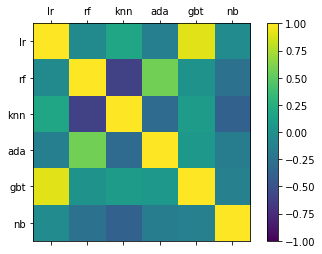

In [415]:
# Correction Matrix Plot

# Get base leaners' mean square error matrix
mse_matrix, names = tuned_model_2.mse_base_learners(X_valid, y_valid)

print()
print("--------- Rows : each clf generated in each cv fold (%d folds here) ----------" % (cv_folds))

# Construct a dataframe and then calculate compute pairwise correlation of columns (base learners)
mse_df = pd.DataFrame(mse_matrix, columns=names)
display(mse_df)
correlations = mse_df.corr()

# Plot correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
pyplot.show()